imports

In [61]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import random
from torch.optim import Adam


DATASET_PATH = "../data"
savedModels_PATH = "finalProduct2"
lossGraph_PATH = "finalGraph"

data

In [62]:

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

def add_uniform_noise(sample):
    return sample.float() + torch.rand_like(sample.float())

def scale_to_unit_interval(sample):
    return sample / 255.0
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 128

x_dim  = 784
hidden_dim = 128
latent_dim = 64

lr = 1e-3

epochs = 10

static_var = 0.1

transform = transforms.Compose([
transforms.ToTensor(),
add_uniform_noise,
scale_to_unit_interval
])

train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=16, shuffle=False, drop_last=False)


elbo funciton 

In [63]:
def calc_elbo(x, x_hat, mean, log_var):
    reproduction_loss = torch.sum((x - x_hat)**2 / (2 * static_var**2) + torch.log(static_var * torch.sqrt(torch.tensor(2 * torch.pi))), dim=1)
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1)
    
    return torch.mean(reproduction_loss + KLD)

encoder

In [64]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim, num_conv_layers):
        super(Encoder, self).__init__()
        self.num_conv_layers = num_conv_layers
        self.convs = nn.ModuleList([nn.Conv2d(1, 1, kernel_size=3, stride=2, padding=1) for _ in range(num_conv_layers)])

        # Create a list to store convolutional layers
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        
        # Adjust input_dim to account for the concatenated outputs
        self.FC_input = nn.Linear(input_dim // 4 * num_conv_layers, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear(hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Reshape input
        x = x.view(batch_size, 1, 28, 28)
        
        # Process input through each convolutional layer
        x = self.LeakyReLU(self.conv1(x))
        x = self.LeakyReLU(self.conv2(x))
        
        # Concatenate outputs along the channel dimension
        
        # Flatten the concatenated output
        x = x.view(batch_size, -1)
        
        # Fully connected layers
        x = self.LeakyReLU(self.FC_input(x))
        mean = self.FC_mean(x)
        log_var = self.FC_var(x)
                                                    
        return mean, log_var

decoder

In [65]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dim, hidden_dim, output_dim, num_conv_layers):
        super(Decoder, self).__init__()
        
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        
        # Adjusting for the input size to the deconvolution layers
        deconv_input_dim = (output_dim // 4) * num_conv_layers
        self.FC_output = nn.Linear(hidden_dim, deconv_input_dim)
        
        
        self.deconvs = nn.ModuleList()
        for _ in range(num_conv_layers):
            self.deconvs.append(nn.ConvTranspose2d(num_conv_layers, 1, kernel_size=3, stride=2, padding=1, output_padding=1))
        self.deconv =  nn.ConvTranspose2d(num_conv_layers, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        # Final deconv layer to get to original input size
        self.deconv1 = nn.ConvTranspose2d(1, 1, kernel_size=3, stride=1, padding=1, output_padding=0)
        self.deconv2 = nn.ConvTranspose2d(1, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.LeakyReLU(self.FC_hidden(x))
        
        x = self.LeakyReLU(self.FC_output(x))
        
        # Reshape to the correct dimensions for deconvolution
        batch_size = x.size(0)
        x = x.view(batch_size, -1, 14, 14)  # Assuming the final conv layer outputs 7x7 feature maps
        
        # Process through each deconvolutional layer
        # conv_outputs = [(F.relu(conv(h))) for conv in self.deconvs]
        # x = torch.cat(conv_outputs, dim=1)
        x = self.LeakyReLU(self.deconv1(x))
        x = self.LeakyReLU(self.deconv2(x))
        # Flatten the concatenated output
        x = x.view(batch_size, -1)
    
        x = x.view(batch_size, 28, 28) 
        # Final deconvolution to match the original input dimensions
        x_hat = torch.sigmoid(x)
        x_hat = x_hat.view(batch_size, 784)
        return x_hat

model

In [66]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.Decoder(z)
        
        return x_hat, mean, log_var
    

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, num_conv_layers=1)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim, num_conv_layers=1)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)
with torch.no_grad():
    model.load_state_dict(torch.load(savedModels_PATH))


sample

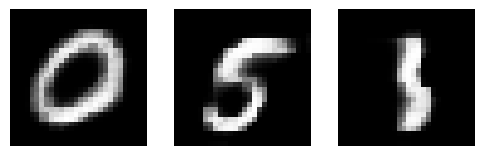

In [67]:
def sample(number_of_images = 1): 
    with torch.no_grad():
        noise = torch.randn(number_of_images, latent_dim).to(DEVICE)
        generated_images = decoder(noise)
        generated_images = generated_images.to('cpu')
        imgs_reshaped = generated_images.view(number_of_images, 28, 28)
        
        # Set up the plot
        fig, axes = plt.subplots(1, number_of_images, figsize=(number_of_images * 2, 2))

        # Plot each image
        for i in range(number_of_images):
            axes[i].imshow(imgs_reshaped[i], cmap='gray')
            axes[i].axis('off')  # Hide axes for better visualization

        plt.show()

sample(3)



question 2

transforms from 7 to 2


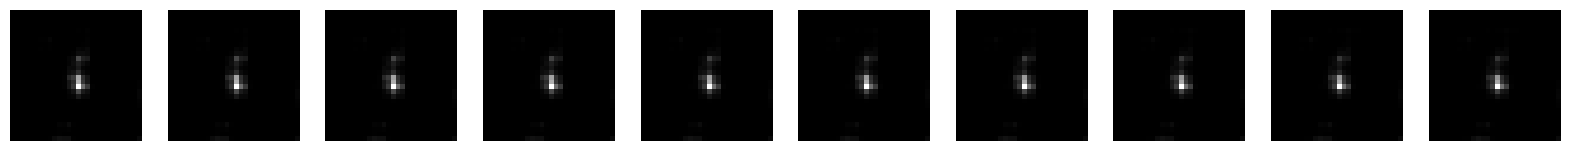

In [69]:
def visualize_images(tensor):
    num_images, squared_size = tensor.shape
    img_size = int(squared_size**0.5)

    # Reshape each image to its 2D shape
    images = tensor.view(num_images, img_size, img_size)
    images = images.detach().numpy()
    # Plot all images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')

    plt.show()


image1 = train_set[1] # 7
image2 = train_set[5] # 2

def transformsDigits(image1, image2):
    model.eval()
    print(f"transforms from {image1[1]} to {image2[1]}")
    image1 = image1[0].to(DEVICE)
    image2 = image2[0].to(DEVICE)
    z1 = model.Encoder(image1)[0][0]
    z2 = model.Encoder(image2)[0][0]
    path = torch.stack([z1 + (i / (9)) * (z2 - z1) for i in range(10)])
    images = model.Decoder(path)
    visualize_images(images.cpu())

plt.close('all')
transformsDigits(image1, image2)